# MONAI Auto3Dseg "Hello World" Example

In this notebook, we will provide a simple demonstration of how to use Auto3Dseg AutoRunner to process a simulated datasets and generate results within minutes.

## 1. Set up environment, imports and datasets

### 1.1 Set up Environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"

### 1.2 Set up imports

In [2]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.data import create_test_image_3d

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3 Simulate a special datasets

It is well known that AI takes time to train. To provide the "Hello World!" experience of Auto3D in this notebook, we will simulate a small datasets and run trainings only for multiple epocs. Due to the nature of AI, the performance shouldn't be highly expected, but the entire pipeline will be completed within minutes!

`sim_datalist` provides the information of the simulated datasets. It lists 12 training and 2 testing images and labels. The training data are split into 3 folds. Each fold will use 8 images to train and 4 images to validate. The size of the dimension is defined by the `sim_dim` .

In [3]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 1, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 1, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 1, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 1, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 2, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 2, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 2, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 2, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

### 1.4 Generate images and labels

Now we can use MONAI `create_test_image_3d` and `nib.Nifti1Image` functions to generate the 3D simulated images under the work_dir

In [4]:
work_dir = "./auto3dseg_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, 'w') as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

### 1.5 Inspect the simulated data

Here we picked a slice of the 3D image in the test datasets to get an idea of the simulation

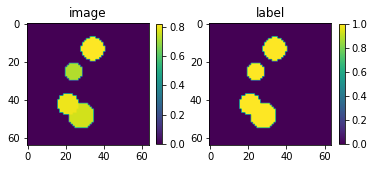

In [5]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist['testing'][0]['image']))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist['testing'][0]['label']))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title('image')
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title('label')
cbar = plt.colorbar(shrink=0.55)


## 2. Test the Auto3Dsseg AutoRunner pipeline

AutoRunner provides an interface to run the Auot3Dseg pipeline. It will automatically configure four different neural networks and perform multi-fold training to achieve the state-of-the-art performance. The module is highly configurable, but only requires minimal user inputs. In this example, we want to complete the piepline in two minutes, so we need to have some customizations

### 2.1 Set up the AutoRunner with default settings

In [6]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    }
)
# runner.run() # this will use the default settings and take hours/ to run 

2022-09-22 03:35:21,886 - INFO - Work directory ./auto3dseg_work_dir is used to save all results
2022-09-22 03:35:21,895 - INFO - The output_dir is not specified. /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/ensemble_output will be used to save ensemble predictions
2022-09-22 03:35:21,897 - INFO - Directory /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/ensemble_output is created to save ensemble predictions


### 2.2 Override the training parameters so that we can complete the pipeline in minutes

In [7]:
max_epochs = 2

# safeguard to ensure max_epochs is greater or equal to 2
max_epochs = max(max_epochs, 2)

train_param = {
    "CUDA_VISIBLE_DEVICES": [0],  # use only 1 gpu
    "num_iterations": 4 * max_epochs,
    "num_iterations_per_validation": 2 * max_epochs,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_iterations": 2 * max_epochs,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

### 2.3 Start the data anlaysis, algorithm generation, training, and model ensemble

In [8]:
runner.run()

100%|██████████| 12/12 [00:02<00:00,  4.84it/s]
algo_templates.tar.gz: 100%|██████████| 280k/280k [00:00<00:00, 382kB/s]  

2022-09-22 03:35:29,243 - INFO - Downloaded: /tmp/tmpvkd67w4k/algo_templates.tar.gz
2022-09-22 03:35:29,245 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpvkd67w4k/algo_templates.tar.gz.
2022-09-22 03:35:29,247 - INFO - Writing into directory: /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir.


2022-09-22 03:35:29,440 - INFO - /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet2d_0
2022-09-22 03:35:29,646 - INFO - /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/dints_0
2022-09-22 03:35:29,761 - INFO - /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/swinunetr_0
2022-09-22 03:35:29,885 - INFO - /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet_0
2022-09-22 03:35:29,886 - INFO - Launching: python /workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet_0/scripts/train.py run --config_file='/workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet_0/configs/transforms_validate.yaml','/workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet_0/configs/transforms_train.yaml','/workspace/monai/tutorials-in-dev/auto3dseg/notebooks/auto3dseg_work_dir/segresnet_0/configs/transforms_infer.yaml','/wor

### 2.4 Inspect the algo ensembled predctions and compare it with the ground truth

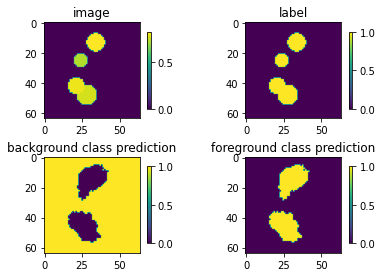

In [9]:
image_name = sim_datalist['testing'][0]['image'].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, 'ensemble_output', image_name, image_name+"_ensemble"+".nii.gz"))
pred = np.array(prediction_nib.dataobj)

plt.subplot(2, 2, 1)
plt.imshow(img[32])
plt.title('image')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(lbl[32])
plt.title('label')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(pred[32, :, :, 0])
plt.title('background class prediction')
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(pred[32, :, :, 1])
plt.title('foreground class prediction')
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

## 3. Conclusion

Here we complete the entire pipeline. As you may notice, we can see the algorithms start to learn the datasets and the prediction of background and foreground voxels. Auto3Dseg and AutoRunner are highly configurable. To get better results, you can increase the training time, apply different ensemble method, or use hyper-parameter optimization through the AutoRunner or Auto3Dseg module APIs.

As a "Hello World" notebook, we will end the experiment with simulated datasets here.